In [21]:
import os
import pandas as pd
import sqlite3

df=pd.read_csv('argo_dummy.csv')
conn = sqlite3.connect("argo.db")
df.to_sql("argo_profiles", conn, if_exists="replace", index=False)

conn.close()
print("✅ Data saved into argo.db (table: argo_profiles)")


✅ Data saved into argo.db (table: argo_profiles)


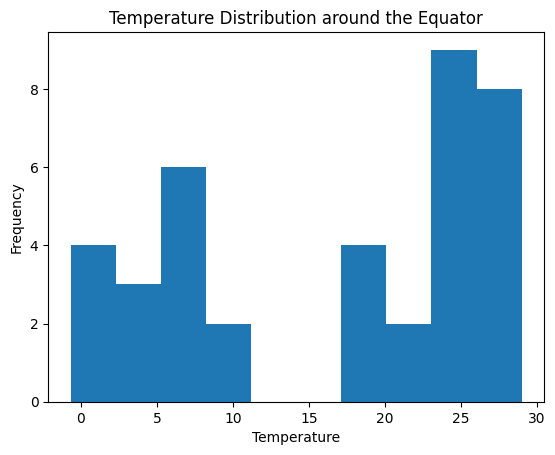

In [29]:
from langchain_community.agent_toolkits import create_sql_agent
from langchain_community.utilities import SQLDatabase
from langchain_experimental.tools import PythonREPLTool
from langchain.agents import initialize_agent, AgentType
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from dotenv import load_dotenv  
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage
load_dotenv()
# 1. Connect to your SQLite DB
db = SQLDatabase.from_uri("sqlite:///argo.db")
if not os.environ.get("GROQ_API_KEY"):
  os.environ["GROQ_API_KEY"] = getpass.getpass("Enter API key for Groq: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gemma2-9b-it", model_provider="groq")

from langchain_core.tools import Tool
from langchain_experimental.utilities import PythonREPL
python_repl = PythonREPL()

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    remaining_steps: int


repl_tool = Tool(
    name="python_repl",
    description="A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.",
    func=python_repl.run,
)
tools = toolkit.get_tools() + [repl_tool]


sql_agent = create_sql_agent(llm, db=db, verbose=True)
checkpointer = InMemorySaver()

from langgraph.prebuilt import create_react_agent
agent = create_react_agent(
    model=llm,  
    tools=tools, 
    # state_schema=ChatState ,
    prompt='''You are a helpful assistant, user will give you a prompt ,based on that first you will answer with logic from database and nlp , descrive your answers and then create visualization plots such as histogram or barplots using matplotlib and seaborn by fetching values from database.dont take much time and only give answers for 5 values from database, also explain the query with the database logic and only create graphs if needed
    , given columns:float_id,date,latitude,longitude,depth,temperature,salinity,pressure,oxygen,pH,conductivity,region
    and table name: argo_profiles, dont iterate much between tools and give final answer as a graph only. recursion limit =5
    IMPORTANT: after creating plots also do plt.savefig("output.png") at the end
    ''',
    # checkpointer=checkpointer,
)


agent.invoke(
    {"messages": [{"role": "user", "content": "temperaturea around equator"}]}
)


graph = StateGraph(ChatState)
graph.add_node("chat_node", agent)
graph.add_edge(START, "chat_node")
graph.add_edge("chat_node", END)

chatbot = graph.compile(checkpointer=checkpointer)
# print("🤖 Answer:", response)

#You are a helpful assistant, user will give you a prompt based on that look into the database fetch some values, and generate code for
    # the visulaization and then give it to python repl to run the code and get the visualization.dont take much time and only give answers for 5 values from database
    # , given columns:float_id,date,latitude,longitude,depth,temperature,salinity,pressure,oxygen,pH,conductivity,region
    # and table name: argo_profiles